In [1]:
# !pip install --user scikit-image
# !pip install --upgrade python-bidi
# !pip install torchmetrics

In [2]:
import sys
sys.path.append("./EasyOCR")

In [3]:
from torch.utils.data import Dataset
from PIL import Image
import json
import os
import random
import numpy as np
import torch
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
from pythainlp.tokenize import word_tokenize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device : {device}')

Device : cuda


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Dataset

In [5]:
from torch.utils.data import Dataset
from PIL import Image
import os
import json
import torchvision.transforms as T

class EasyOCRDataset(Dataset):
    def __init__(self, data_root, img_height=128, img_width=600, gt_filename="train_list.txt"):
        """
        data_root/
        ├── train_list.txt          # lines: th_img/0/<word_1>.png\t<label>
        └── th_dict.txt
        └── 0/
            ├ <word_1>.jpg
            ├ <word_2>.jpg
            └ ...
        """
        self.data_root = data_root
        self.image_dir = os.path.join(data_root, "train")
        gt_path = os.path.join(data_root, gt_filename)

        # read gt.txt into a list of (relative_path, label)
        self.samples = []
        with open(gt_path, "r", encoding="utf-8") as f:
            for line in f:
                rel_path, label = line.strip().split("\t", 1)
                self.samples.append((rel_path, label))

        # transforms: grayscale → resize → tensor → normalize
        self.transform = T.Compose([
            T.Grayscale(num_output_channels=1),
            T.Resize((img_height, img_width)),
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        rel_path, label = self.samples[idx]
        img_path = rel_path

        # load & transform
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)  # [1, H, W]

        return image, label

In [6]:
import torch
from torch.utils.data import DataLoader, random_split, Subset

# Load the dataset
train_dataset = EasyOCRDataset("./th_img", gt_filename="train_list.txt")
valid_dataset = EasyOCRDataset("./th_img", gt_filename="val_list.txt")

# Set seed for reproducibility
seed = 42
batch_size = 16
generator = torch.Generator().manual_seed(seed)

# Shuffle indices manually
indices = list(range(len(train_dataset)))
random.Random(seed).shuffle(indices)

# # Take only the first 100000 shuffled indices
# limited_indices = indices[:100000]
limited_indices = indices[:]

# Create a shuffled subset
shuffled_train_set = Subset(train_dataset, limited_indices)

# Split lengths
train_len = len(shuffled_train_set)
val_test_len = len(valid_dataset)
valid_len = int(val_test_len * 0.5)
test_len = val_test_len - valid_len

# Split the dataset
valid_set, test_set = random_split(valid_dataset, [valid_len, test_len], generator=generator)

# Create DataLoaders
train_loader = DataLoader(shuffled_train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

In [7]:
# simple validation loop
def validate(model, loader, converter, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            logits = model(imgs)           # raw CTC logits
            preds  = converter.decode(logits.softmax(-1))
            for p,t in zip(preds, labels):
                if p == t: correct += 1
                total  += 1
    return correct/total

In [8]:
print(f'Len Training data : {train_len}')

Len Training data : 197995


In [9]:
print(f'Len Valid data : {valid_len}')

Len Valid data : 1000


In [10]:
print(f'Len Test data : {test_len}')

Len Test data : 1000


In [11]:
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

torch.Size([16, 1, 128, 600])
('หรือประกันสังคม', 'ป.ป.ช.หรือไม่', '204/1', '๓๘๑', 'อาจมาจากพม่า', 'กลัวโดนทำโทษ', 'คือสมชาย', 'นครไป', 'ไปให้มันยิงอีก', 'ผ่านสยามพารากอล', '(王文華)', 'กานไม้', 'มีนายมูหัมมัด', 'จุลพันธุ์', 'ครัมเมอนาเช', 'และเมื่อมีการทำ')


In [12]:
labels

('หรือประกันสังคม',
 'ป.ป.ช.หรือไม่',
 '204/1',
 '๓๘๑',
 'อาจมาจากพม่า',
 'กลัวโดนทำโทษ',
 'คือสมชาย',
 'นครไป',
 'ไปให้มันยิงอีก',
 'ผ่านสยามพารากอล',
 '(王文華)',
 'กานไม้',
 'มีนายมูหัมมัด',
 'จุลพันธุ์',
 'ครัมเมอนาเช',
 'และเมื่อมีการทำ')

หรือประกันสังคม
ป.ป.ช.หรือไม่
204/1
๓๘๑
อาจมาจากพม่า
กลัวโดนทำโทษ
คือสมชาย
นครไป


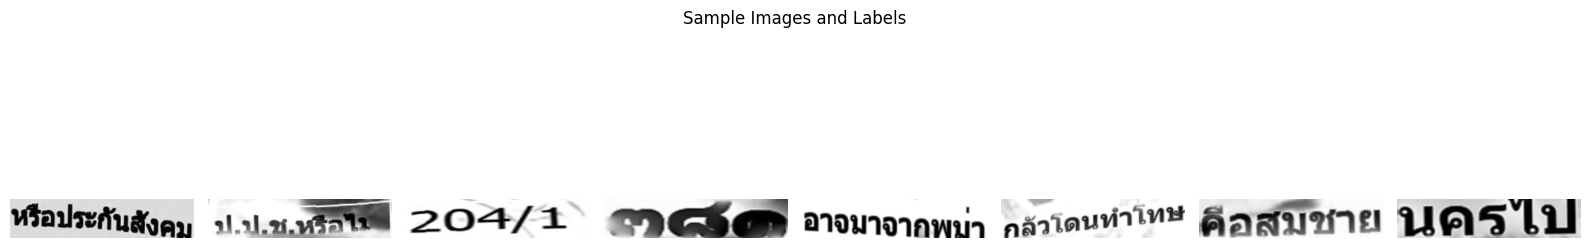

In [13]:
# Pick a few samples to display
num_to_display = 8
images_to_show = images[:num_to_display]
labels_to_show = labels[:num_to_display]

# Denormalize images (from [-1, 1] back to [0, 1])
images_to_show = images_to_show * 0.5 + 0.5  # Because normalized with mean=0.5, std=0.5

# Plot
plt.figure(figsize=(16, 4))
for i in range(num_to_display):
    img = images_to_show[i].squeeze(0).cpu().numpy()  # shape: [32, 160]
    print(labels_to_show[i][:30])

    plt.subplot(1, num_to_display, i + 1)
    plt.imshow(img, cmap='gray')
    #plt.title(f"{labels_to_show[i][:30]}...", fontsize=8)  # Truncate long text
    plt.axis('off')

plt.suptitle("Sample Images and Labels", fontsize=12)
plt.tight_layout()
plt.show()

# Model

In [14]:
# import torch.nn as nn
# from EasyOCR.easyocr.easyocr import Reader

# # Step 1: Initialize Reader for Thai
# reader = Reader(['th'], gpu=True)
# character_set = reader.character  # this is the character set used by the model

# # === Step 1: Prepare Model Config ===
# lang = 'th_custom'
# # recog_network = 'generation1' # Or another network architecture
# device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
# import torch
# from torchvision import transforms
# from PIL import Image, ImageEnhance
# from collections import OrderedDict
# import importlib
# import numpy as np
# import torch.nn.functional as F

# from EasyOCR.easyocr.utils import CTCLabelConverter
# from EasyOCR.easyocr.config import recognition_models

# # === Step 1: Prepare Model Config ===
# lang = 'th'
# recog_network = 'generation1'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model_config = recognition_models['gen1']['thai_g1']

# # character = model_config['characters']
# character = character_set
# model_path = f'./pretrained/{model_config["filename"]}'

# # === Step 2: Setup Converter & Params ===
# converter = CTCLabelConverter(character)
# num_class = len(converter.character)
# ignore_idx = []

# network_params = {
#     'input_channel': 1,
#     'output_channel': 512,
#     'hidden_size': 512
# }

# # === Step 3: Load Model with Strict Check ===
# model_pkg = importlib.import_module("easyocr.model.model")
# model = model_pkg.Model(num_class=num_class, **network_params)

# state_dict = torch.load(model_path, map_location=device)
# new_state_dict = OrderedDict((k[7:], v) if k.startswith("module.") else (k, v) for k, v in state_dict.items())

# load_result = model.load_state_dict(new_state_dict, strict=False)
# if load_result.missing_keys or load_result.unexpected_keys:
#     print("⚠️ Weight loading issues:")
#     if load_result.missing_keys:
#         print("Missing keys:", load_result.missing_keys)
#     if load_result.unexpected_keys:
#         print("Unexpected keys:", load_result.unexpected_keys)
#     raise ValueError("Model weights mismatch. Aborting due to strict=True policy.")
    

# model.load_state_dict(new_state_dict, strict=True)
# model = model.to(device)

In [16]:
import torch
from torchvision import transforms
from PIL import Image, ImageEnhance
from collections import OrderedDict
import importlib
import numpy as np
import torch.nn.functional as F

from easyocr.utils import CTCLabelConverter
from easyocr.config import recognition_models

In [17]:
def get_labels_from_txt(label_path, delim="\t"):
    all_labels = []
    with open(label_path, "r", encoding="utf-8") as f:
        for line in f:
            rel_path, label = line.strip().split(delim, 1)
            all_labels.append(label)

    return all_labels

In [18]:
# === Step 1: Prepare Model Config ===
lang = 'th'
recog_network = 'generation1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_config = recognition_models['gen1']['thai_g1']

# read th_dict.txt into a list of labels
dict_path = "th_img/th_dict.txt"
chars = []

with open(dict_path, "r", encoding="utf-8") as f:
    for line in f:
        char = line.split("\n", -1)[0]
        chars.append(char)

# Create a set of all unique characters present in your text dictionary
base_character_set = "".join(set("".join(chars)))


# read train_list.txt into a list of labels
all_labels = get_labels_from_txt("th_img/train_list.txt")
val_labels = get_labels_from_txt("th_img/val_list.txt")
all_labels.extend(val_labels)

# Create a set of all unique characters present in your text data
all_chars_from_text = set("".join(all_labels))
# Convert your base character set to a set for easy comparison
existing_chars_set = set(base_character_set)
newly_found_chars = all_chars_from_text - existing_chars_set

character_set = base_character_set

if newly_found_chars:
    # Sort the new characters for consistent ordering
    new_chars_to_add = "".join(sorted(list(newly_found_chars)))
    
    print(f"✅ Found {len(new_chars_to_add)} new character(s) missing from your set:")
    print(f"   New Characters: {new_chars_to_add}")
    
    # Append the new characters to your base set
    character_set += new_chars_to_add
    
    print(f"\nUpdated character set size: {len(character_set)}")

else:
    print("✅ No new characters were found.")
    print("   Your character set is already complete for this data.")

print("-" * 50)

✅ Found 157 new character(s) missing from your set:
   New Characters: ¡¢¤§´¶·¹º¾ÁÃÄÅÇÉÍÒÓÙàáâäçèéíïòóùüćıآأإابتجدرسضعقكلمنهويٌَُِّْچڠڤฦฺๅ๐๑๒๓๔๕๖๗๘๙ຂງຕນບປພສອັາິີືົເ່ỏốự​‎‏–—‘’•‪‬、がしにのみッドバラ八凱大安家平年幸廸张快文新朱果樂王祝福華鄉陈교대상육정학화！

Updated character set size: 333
--------------------------------------------------


In [19]:
# Use the custom character set
character = character_set
model_path = f'./pretrained/{model_config["filename"]}'

# === Step 2: Setup Converter & Params ===
converter = CTCLabelConverter(character)
num_class = len(converter.character)
# The ignore_idx is handled by the converter, no need to set it manually

network_params = {
    'input_channel': 1,
    'output_channel': 512,
    'hidden_size': 512,
    'num_class': num_class  # Pass num_class to the model constructor
}

# === Step 3: Load Model with Strict Check ===
model_pkg = importlib.import_module("easyocr.model.model")
# Ensure the model architecture matches what you're loading
# If you are using a custom model, you might need to adjust this.
# For standard models, the network_params should be sufficient.
model = model_pkg.Model(**network_params)

# It's generally better to load the pretrained model first and then
# adapt the final classification layer for your custom number of classes.

# Load the pretrained weights
state_dict = torch.load(model_path, map_location=device)
# First, create the new state_dict by stripping the 'module.' prefix
new_state_dict = OrderedDict((k[7:], v) if k.startswith("module.") else (k, v) for k, v in state_dict.items())

# **DEBUG**: Print all the keys in the new state_dict to see what's available
print("Keys available in the model's state_dict:")
print(list(new_state_dict.keys()))
print("-" * 50)


# Now, access the cleaned key 'Prediction.weight' to get the size
# Also, add a check to ensure the key exists before accessing it
prediction_weight_key = 'Prediction.weight'
if prediction_weight_key not in new_state_dict:
    raise KeyError(f"The key '{prediction_weight_key}' was not found in the model state_dict. "
                   f"Please check the printed keys above to find the correct key for the final prediction layer's weights.")

pretrained_num_class = new_state_dict[prediction_weight_key].shape[0]

# If the number of classes is different, re-initialize the final layer.
if num_class != pretrained_num_class:
    print(f"⚠️ Number of classes differs. Pretrained model has {pretrained_num_class}, your model has {num_class}.")
    print("Re-initializing the final prediction layer.")
    # Remove the old prediction layer weights so they aren't loaded
    del new_state_dict['Prediction.weight']
    del new_state_dict['Prediction.bias']

    # Load all other weights with strict=False
    load_result = model.load_state_dict(new_state_dict, strict=False)
    print("Missing keys:", load_result.missing_keys) # Should be ['Prediction.weight', 'Prediction.bias']
    print("Unexpected keys:", load_result.unexpected_keys)

else:
    # If number of classes is the same, load everything strictly
    model.load_state_dict(new_state_dict, strict=True)

model = model.to(device)

print("\n✅ Model setup complete with the custom character set.")
print(f"Character set contains {len(character)} characters.")

C:\Users\Admin\AppData\Local\Temp\ipykernel_25548\2157011951.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


Keys available in the model's state_dict:
['FeatureExtraction.ConvNet.conv0_1.weight', 'FeatureExtraction.ConvNet.bn0_1.weight', 'FeatureExtraction.ConvNet.bn0_1.bias', 'FeatureExtraction.ConvNet.bn0_1.running_mean', 'FeatureExtraction.ConvNet.bn0_1.running_var', 'FeatureExtraction.ConvNet.bn0_1.num_batches_tracked', 'FeatureExtraction.ConvNet.conv0_2.weight', 'FeatureExtraction.ConvNet.bn0_2.weight', 'FeatureExtraction.ConvNet.bn0_2.bias', 'FeatureExtraction.ConvNet.bn0_2.running_mean', 'FeatureExtraction.ConvNet.bn0_2.running_var', 'FeatureExtraction.ConvNet.bn0_2.num_batches_tracked', 'FeatureExtraction.ConvNet.layer1.0.conv1.weight', 'FeatureExtraction.ConvNet.layer1.0.bn1.weight', 'FeatureExtraction.ConvNet.layer1.0.bn1.bias', 'FeatureExtraction.ConvNet.layer1.0.bn1.running_mean', 'FeatureExtraction.ConvNet.layer1.0.bn1.running_var', 'FeatureExtraction.ConvNet.layer1.0.bn1.num_batches_tracked', 'FeatureExtraction.ConvNet.layer1.0.conv2.weight', 'FeatureExtraction.ConvNet.layer1.0.

In [20]:
len(character)

333

In [21]:
# Folder setup
metrics_dir = "metrics/synth-v3"
model_dir = "models/synth-v3"
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

# The path where you want to save the file
char_file_path = os.path.join(model_dir, "custom_char.txt")

try:
    # Use 'utf-8' encoding, which is crucial for handling Thai characters
    with open(char_file_path, 'w', encoding='utf-8') as f:
        f.write(character_set)
    
    print(f"✅ Character set successfully saved to: {char_file_path}")
    print(f"\tTotal characters saved: {len(character_set)}")

except Exception as e:
    print(f"⚠️ An error occurred: {e}")

✅ Character set successfully saved to: models/synth-v3\custom_char.txt
	Total characters saved: 333


In [22]:
for param in model.FeatureExtraction.parameters():
    param.requires_grad = False
for param in model.FeatureExtraction.ConvNet.layer4.parameters():
    param.requires_grad = True

In [23]:
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔒 Frozen parameters: {frozen_params:,}")
print(f"🟢 Trainable parameters: {trainable_params:,}")
print(f"📊 Total parameters: {frozen_params + trainable_params:,}")

🔒 Frozen parameters: 30,101,984
🟢 Trainable parameters: 23,787,854
📊 Total parameters: 53,889,838


In [24]:
import torch.nn as nn
import torch.optim as optim

criterion = torch.nn.CTCLoss(zero_infinity=True).to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# Train

c:\Users\Admin\anaconda3\envs\dsai\lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
Epoch 1/10 [Training]: 100%|██████████| 12375/12375 [1:18:30<00:00,  2.63it/s, loss=0.404]  


Epoch 1: Train Loss = 0.4041
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.1418 | CER = 0.0319 | WER = 0.2290
✅ New best model saved to: models/synth-v3\thai.pth (CER: 0.0319)


Epoch 2/10 [Training]: 100%|██████████| 12375/12375 [1:05:35<00:00,  3.14it/s, loss=0.0117] 


Epoch 2: Train Loss = 0.0117
⚠️ Skipped 1 empty predictions this epoch
Validation Loss = 0.1189 | CER = 0.0249 | WER = 0.1792
✅ New best model saved to: models/synth-v3\thai.pth (CER: 0.0249)
✅ Checkpoint 2 saved to: models/synth-v3\checkpoint_2.pth

🔍 Debug Sample Predictions (Epoch 2, First 10):
GT   : 'เริ่มโครงการ'
PRED : 'เริ่มโครงการ'
---
GT   : 'พูดง่ายง่าย'
PRED : 'พูดง่ายง่าย'
---
GT   : 'สวลี'
PRED : 'สว'
---
GT   : 'โคตรคุ้มพี่น้อง'
PRED : 'โคตรค้มพี่น้อง'
---
GT   : 'ในมุมมองของเขา'
PRED : 'ในมุมมองของเขา'
---
GT   : 'ปลาหมึกสาย'
PRED : 'ปลาหมิภสาย'
---
GT   : 'ธนเทพ'
PRED : 'ธนเทพ'
---
GT   : '(VGHC)'
PRED : '(VGHC)'
---
GT   : 'คำปัน.'
PRED : 'คำบัน.'
---
GT   : 'ภักดิ์คีรี'
PRED : '.ภักด์อ'
---


Epoch 3/10 [Training]: 100%|██████████| 12375/12375 [1:05:00<00:00,  3.17it/s, loss=0.0558] 


Epoch 3: Train Loss = 0.0558
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0741 | CER = 0.0185 | WER = 0.1310
✅ New best model saved to: models/synth-v3\thai.pth (CER: 0.0185)


Epoch 4/10 [Training]: 100%|██████████| 12375/12375 [1:05:07<00:00,  3.17it/s, loss=0.0427] 


Epoch 4: Train Loss = 0.0427
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0657 | CER = 0.0165 | WER = 0.1360
✅ New best model saved to: models/synth-v3\thai.pth (CER: 0.0165)
✅ Checkpoint 4 saved to: models/synth-v3\checkpoint_4.pth

🔍 Debug Sample Predictions (Epoch 4, First 10):
GT   : 'เริ่มโครงการ'
PRED : 'เริ่มโครงการ'
---
GT   : 'พูดง่ายง่าย'
PRED : 'พูดง่ายง่าย'
---
GT   : 'สวลี'
PRED : 'สวมี'
---
GT   : 'โคตรคุ้มพี่น้อง'
PRED : 'โคตรค้มพี่น้อง'
---
GT   : 'ในมุมมองของเขา'
PRED : 'ในมุมมองของเขา'
---
GT   : 'ปลาหมึกสาย'
PRED : 'ปลาหมิกสาย'
---
GT   : 'ธนเทพ'
PRED : 'ธนเทพ'
---
GT   : '(VGHC)'
PRED : '(VGHC)'
---
GT   : 'คำปัน.'
PRED : 'คำบัน.'
---
GT   : 'ภักดิ์คีรี'
PRED : 'ภักด์ค์'
---


Epoch 5/10 [Training]: 100%|██████████| 12375/12375 [1:05:07<00:00,  3.17it/s, loss=0.0749] 


Epoch 5: Train Loss = 0.0749
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0542 | CER = 0.0132 | WER = 0.1080
✅ New best model saved to: models/synth-v3\thai.pth (CER: 0.0132)


Epoch 6/10 [Training]: 100%|██████████| 12375/12375 [1:13:22<00:00,  2.81it/s, loss=0.0613] 


Epoch 6: Train Loss = 0.0613
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0557 | CER = 0.0132 | WER = 0.1100
✅ Checkpoint 6 saved to: models/synth-v3\checkpoint_6.pth

🔍 Debug Sample Predictions (Epoch 6, First 10):
GT   : 'เริ่มโครงการ'
PRED : 'เริ่มโครงการ'
---
GT   : 'พูดง่ายง่าย'
PRED : 'พูดง่ายง่าย'
---
GT   : 'สวลี'
PRED : 'สวดี'
---
GT   : 'โคตรคุ้มพี่น้อง'
PRED : 'โคตรค้มพี่น้อง'
---
GT   : 'ในมุมมองของเขา'
PRED : 'ในมุมมองของเขา'
---
GT   : 'ปลาหมึกสาย'
PRED : 'ปลาหมิกสาย'
---
GT   : 'ธนเทพ'
PRED : 'ธนเทพ'
---
GT   : '(VGHC)'
PRED : '(vGHC)'
---
GT   : 'คำปัน.'
PRED : 'คำปัน.'
---
GT   : 'ภักดิ์คีรี'
PRED : 'ภักด์ค'
---


Epoch 7/10 [Training]: 100%|██████████| 12375/12375 [1:10:22<00:00,  2.93it/s, loss=0.00284] 


Epoch 7: Train Loss = 0.0028
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0566 | CER = 0.0140 | WER = 0.1090


Epoch 8/10 [Training]: 100%|██████████| 12375/12375 [1:05:09<00:00,  3.16it/s, loss=0.0338]  


Epoch 8: Train Loss = 0.0338
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0499 | CER = 0.0108 | WER = 0.0870
✅ New best model saved to: models/synth-v3\thai.pth (CER: 0.0108)
✅ Checkpoint 8 saved to: models/synth-v3\checkpoint_8.pth

🔍 Debug Sample Predictions (Epoch 8, First 10):
GT   : 'เริ่มโครงการ'
PRED : 'เริ่มโครงการ'
---
GT   : 'พูดง่ายง่าย'
PRED : 'พูดง่ายง่าย'
---
GT   : 'สวลี'
PRED : 'สวลี'
---
GT   : 'โคตรคุ้มพี่น้อง'
PRED : 'โคตรค้มพี่น้อง'
---
GT   : 'ในมุมมองของเขา'
PRED : 'ในมุมมองของเขา'
---
GT   : 'ปลาหมึกสาย'
PRED : 'ปลาหมึกสาย'
---
GT   : 'ธนเทพ'
PRED : 'ธนเทพ'
---
GT   : '(VGHC)'
PRED : '(VGHC)'
---
GT   : 'คำปัน.'
PRED : 'คำปัน.'
---
GT   : 'ภักดิ์คีรี'
PRED : 'ภักดิ์อีี'
---


Epoch 9/10 [Training]: 100%|██████████| 12375/12375 [1:04:57<00:00,  3.18it/s, loss=0.115]   


Epoch 9: Train Loss = 0.1147
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0450 | CER = 0.0097 | WER = 0.0880
✅ New best model saved to: models/synth-v3\thai.pth (CER: 0.0097)


Epoch 10/10 [Training]: 100%|██████████| 12375/12375 [1:05:16<00:00,  3.16it/s, loss=0.00107] 


Epoch 10: Train Loss = 0.0011
⚠️ Skipped 0 empty predictions this epoch
Validation Loss = 0.0366 | CER = 0.0090 | WER = 0.0770
✅ New best model saved to: models/synth-v3\thai.pth (CER: 0.0090)
✅ Checkpoint 10 saved to: models/synth-v3\checkpoint_10.pth

🔍 Debug Sample Predictions (Epoch 10, First 10):
GT   : 'เริ่มโครงการ'
PRED : 'เริ่มโครงการ'
---
GT   : 'พูดง่ายง่าย'
PRED : 'พูดง่ายง่าย'
---
GT   : 'สวลี'
PRED : 'สวดี'
---
GT   : 'โคตรคุ้มพี่น้อง'
PRED : 'โคตรค้มพี่น้อง'
---
GT   : 'ในมุมมองของเขา'
PRED : 'ในมุมมองของเขา'
---
GT   : 'ปลาหมึกสาย'
PRED : 'ปลาหมิภสาย'
---
GT   : 'ธนเทพ'
PRED : 'ธนเทพ'
---
GT   : '(VGHC)'
PRED : '(VGHC)'
---
GT   : 'คำปัน.'
PRED : 'คำปัน.'
---
GT   : 'ภักดิ์คีรี'
PRED : 'ภักดิ์คี์'
---


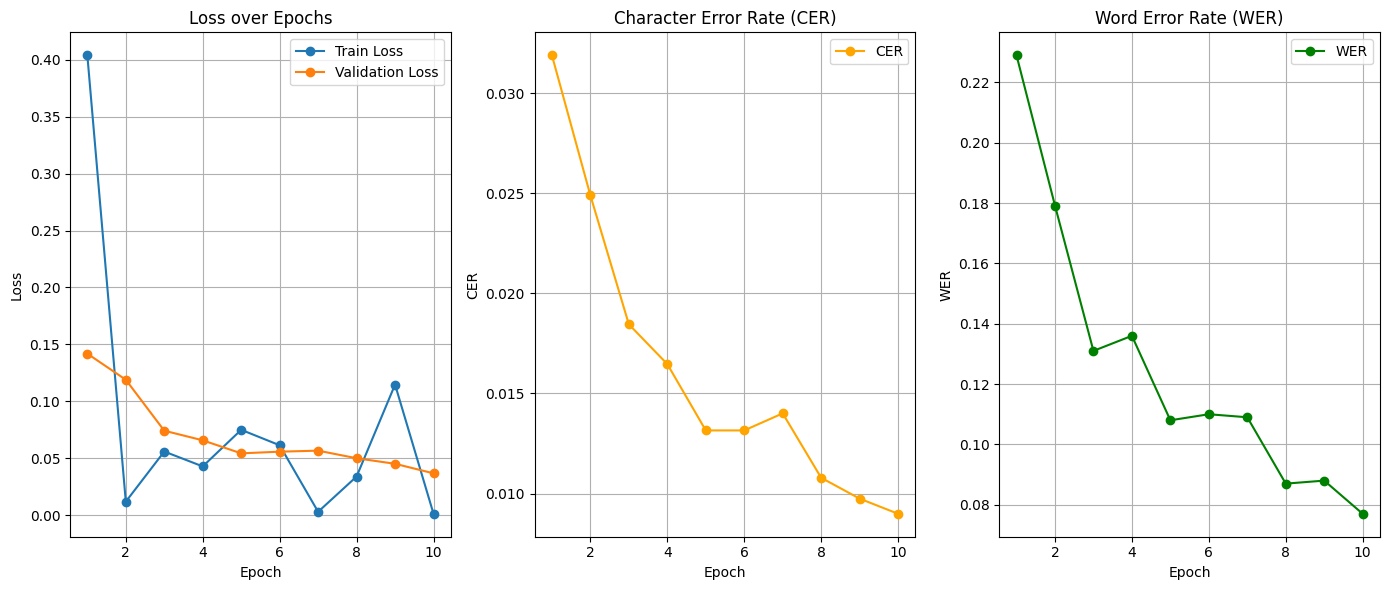

📊 Metrics plot saved to: metrics/synth-v3\training_metrics.png


In [25]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.text import CharErrorRate, WordErrorRate

# === Assume these are already defined ===
# model, optimizer, criterion, converter, train_loader, valid_loader, device

def clean_text(text):
    return text.strip().replace(" ", "").lower()

# === Training Setup ===
num_epochs = 10

train_losses = []
val_losses = []
cer_list = []
wer_list = []
best_cer = float("inf")

# Initialize torchmetrics metrics
cer_metric = CharErrorRate()
wer_metric = WordErrorRate()

for epoch in range(1, num_epochs + 1):
    # === Training ===
    model.train()
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Training]")
    for images, labels in train_bar:
        images = images.to(device)

        targets, lengths = converter.encode(labels)
        targets = targets.to(device)
        lengths = lengths.to(device)

        preds = model(images, text=targets).log_softmax(2)
        batch_size = images.size(0)
        preds_size = torch.IntTensor([preds.size(1)] * batch_size).to(device)
        preds = preds.permute(1, 0, 2)

        loss = criterion(preds, targets, preds_size, lengths)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update the progress bar with current loss
        train_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}")
    train_losses.append(loss.item())

    # === Validation ===
    model.eval()
    val_loss = 0
    preds_str_all = []
    labels_all = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)

            targets, lengths = converter.encode(labels)
            targets = targets.to(device)
            lengths = lengths.to(device)

            preds = model(images, text=targets).log_softmax(2)
            batch_size = images.size(0)
            preds_size = torch.IntTensor([preds.size(1)] * batch_size).to(device)
            preds = preds.permute(1, 0, 2)

            loss = criterion(preds, targets, preds_size, lengths)
            val_loss += loss.item()

            _, preds_index = preds.max(2)  # [B, T]
            preds_index = preds_index.transpose(1, 0).contiguous().view(-1).cpu().numpy()
            preds_size_cpu = preds_size.cpu().numpy()
            preds_str = converter.decode_greedy(preds_index, preds_size_cpu)

            preds_str_all.extend(preds_str)
            labels_all.extend(labels)

    # === Filter out empty preds ===
    preds_filtered = []
    labels_filtered = []
    empty_count = 0

    for p, l in zip(preds_str_all, labels_all):
        if p != "":
            preds_filtered.append(p)
            labels_filtered.append(l)
        else:
            empty_count += 1

    print(f"⚠️ Skipped {empty_count} empty predictions this epoch")

    # === Compute Metrics ===
    if preds_filtered:
        cer = cer_metric(preds_filtered, labels_filtered).item()
        wer = wer_metric(preds_filtered, labels_filtered).item()
    else:
        cer = 1.0
        wer = 1.0
        print("⚠️ No valid predictions to compute metrics for this epoch.")

    avg_val_loss = val_loss / len(valid_loader)

    val_losses.append(avg_val_loss)
    cer_list.append(cer)
    wer_list.append(wer)

    print(f"Validation Loss = {avg_val_loss:.4f} | CER = {cer:.4f} | WER = {wer:.4f}")

    # === Save best model based on CER ===
    if cer < best_cer:
        best_cer = cer
        best_model_path = os.path.join(model_dir, "thai.pth")
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ New best model saved to: {best_model_path} (CER: {cer:.4f})")

    # === Debug: Visual Check on Predictions (every 2 epochs) ===
    if epoch % 2 == 0:
        checkpoint_path = os.path.join(model_dir, f"checkpoint_{epoch}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"✅ Checkpoint {epoch} saved to: {checkpoint_path}")

        print(f"\n🔍 Debug Sample Predictions (Epoch {epoch}, First 10):")
        for i in range(min(10, len(preds_filtered))):
            print(f"GT   : {labels_filtered[i]!r}")
            print(f"PRED : {preds_filtered[i]!r}")
            print("---")

# === Plotting and Saving Metrics ===
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid(True)

# Plot CER
plt.subplot(1, 3, 2)
plt.plot(epochs, cer_list, label="CER", marker='o', color='orange')
plt.xlabel("Epoch")
plt.ylabel("CER")
plt.title("Character Error Rate (CER)")
plt.legend()
plt.grid(True)

# Plot WER
plt.subplot(1, 3, 3)
plt.plot(epochs, wer_list, label="WER", marker='o', color='green')
plt.xlabel("Epoch")
plt.ylabel("WER")
plt.title("Word Error Rate (WER)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plot_path = os.path.join(metrics_dir, "training_metrics.png")
plt.savefig(plot_path)
plt.show()
print(f"📊 Metrics plot saved to: {plot_path}")